## EN4.22 Salinity Processing

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
import pickle
import xesmf as xe

In [3]:
# Get SOCAT grid
socat = xr.open_dataset('/data/artemis/workspace/vbennington/SOCAT/processed/dpCO2_WVCorr_monthly_197901-201912.nc')
dpco2 = socat.dpco2
slat = dpco2.ylat
slon = dpco2.xlon
otime = dpco2.time

In [6]:
# Get Salinity data and grid
en422 = xr.open_dataset('/data/artemis/observations/EN422_salinity/originals/EN422_sss_1979-2020.nc')
salinity = en422.salinity
ylat = salinity.lat
xlon = salinity.lon
depth = salinity.depth
stime = salinity.time

In [7]:
# Prepare to regrid EN4.2.1 Salinity:
sgrid = xr.Dataset({'lat':(['lat'],slat.values),'lon':(['lon'],slon.values)})
egrid = xr.Dataset({'lat':(['lat'],ylat.values),'lon':(['lon'],xlon.values)})
sal = xr.Dataset({'sss':(['time','lat','lon'],salinity[:,0,:,:].values),'time':(['time'],stime.values),'lat':(['lat'],ylat.values),'lon':(['lon'],xlon.values)})

In [8]:
regridder = xe.Regridder(sal, sgrid, 'bilinear','periodic')

Create weight file: bilinear_173x360_180x360_peri.nc


In [9]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_173x360_180x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (173, 360) 
Output grid shape:          (180, 360) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      periodic

In [10]:
sss_new = regridder(salinity[:,0,:,:])

In [11]:
sss_new=ma.masked_where(sss_new==0,sss_new)

In [12]:
sss_new=sss_new.filled(np.nan)

In [13]:
len(ylat)

173

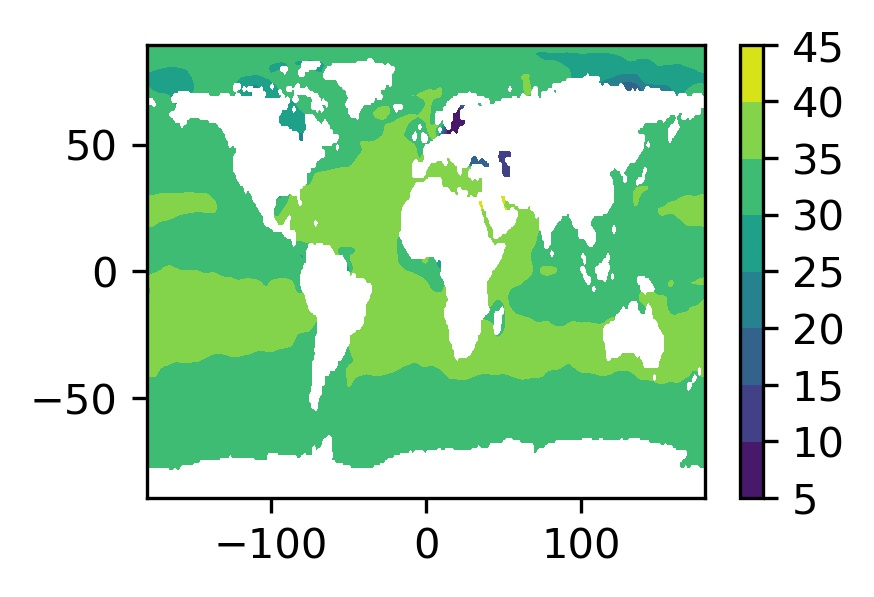

In [14]:
fig = plt.figure(figsize=(3,2))
plt.contourf(slon,slat,sss_new[0,:,:])
plt.colorbar()

In [16]:
np.shape(sss_new)

(504, 180, 360)

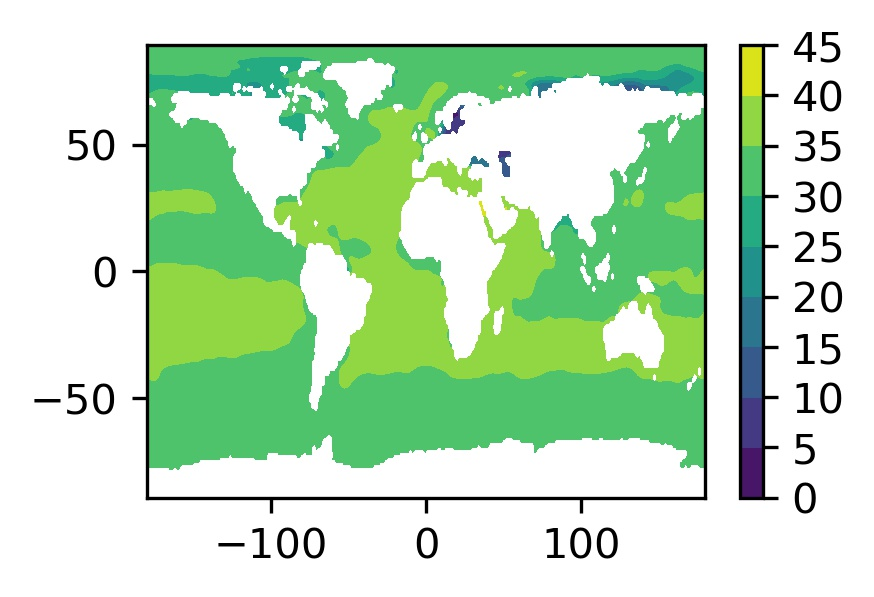

In [18]:
fig = plt.figure(figsize=(3,2))
plt.contourf(slon,slat,sss_new[200,:,:])
plt.colorbar()

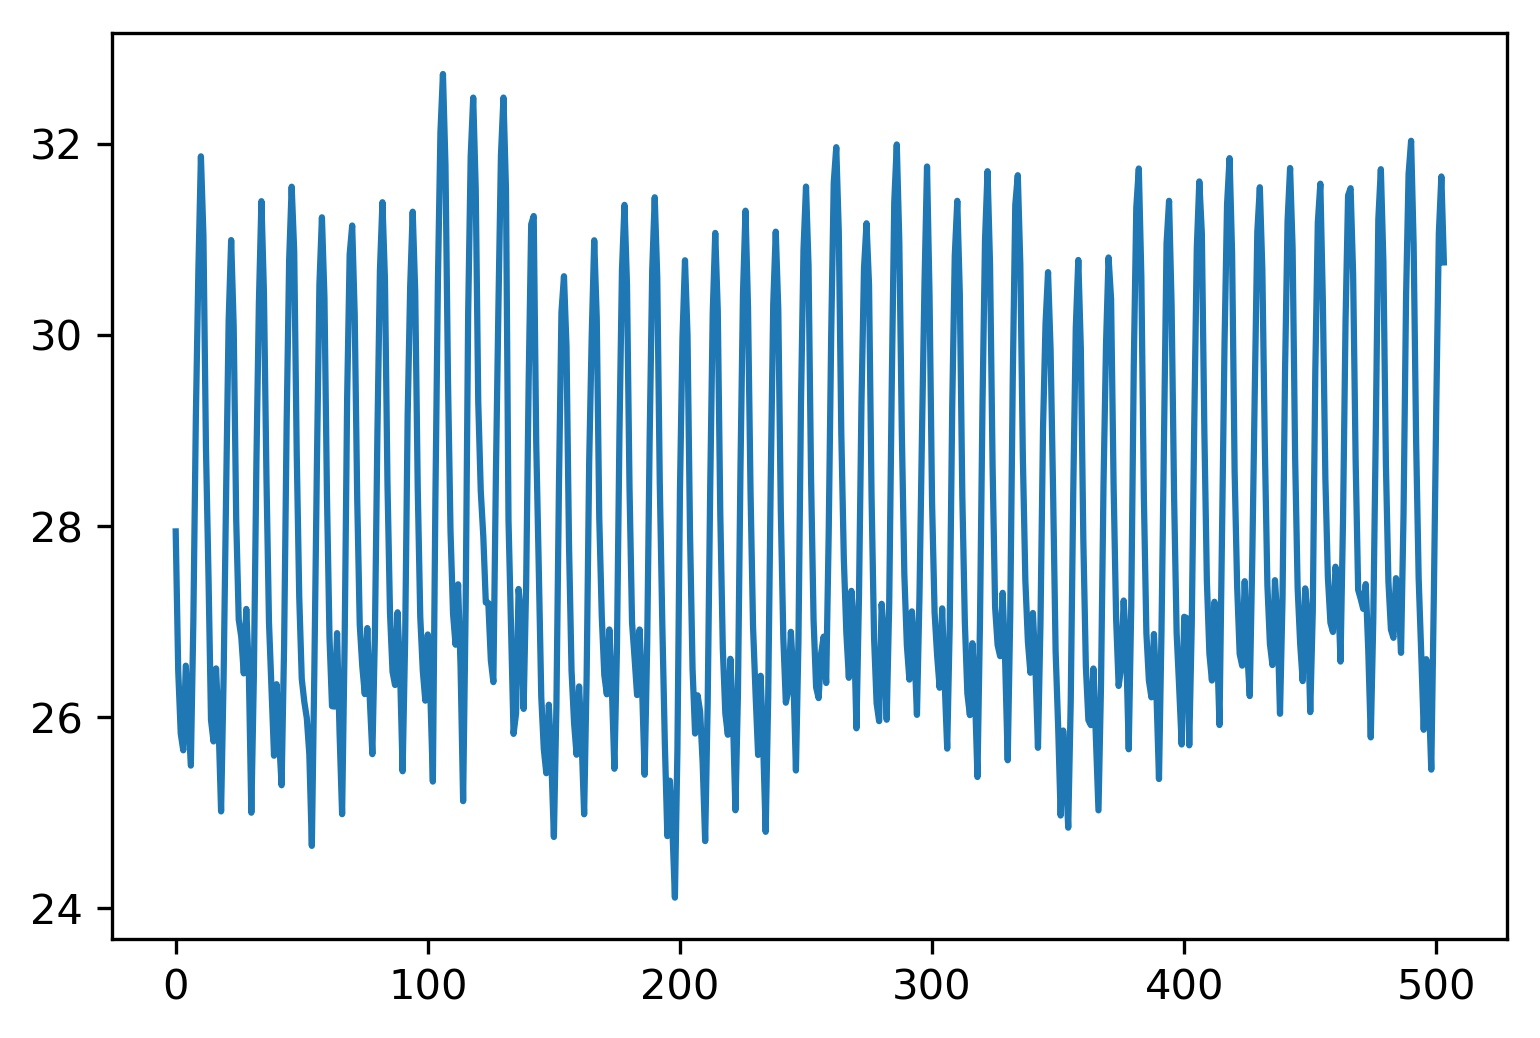

In [19]:
fig = plt.figure()
plt.plot(sss_new[:,90,130])

In [22]:
# Get ready to write to File ####

date_range_start = '1979-01-01T00:00:00.000000000'
date_range_end = '2020-12-30T00:00:00.000000000'

# create date vector
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')


In [23]:
print(dates)

DatetimeIndex(['1979-01-15', '1979-02-15', '1979-03-15', '1979-04-15',
               '1979-05-15', '1979-06-15', '1979-07-15', '1979-08-15',
               '1979-09-15', '1979-10-15',
               ...
               '2020-03-15', '2020-04-15', '2020-05-15', '2020-06-15',
               '2020-07-15', '2020-08-15', '2020-09-15', '2020-10-15',
               '2020-11-15', '2020-12-15'],
              dtype='datetime64[ns]', length=504, freq=None)


In [25]:
# Okay now ready to write to file:
ds_out = xr.Dataset(
                        {
                        'SSS':(["time","ylat","xlon"],sss_new)
                        },
                        coords={'time': (['time'],dates),
                               'ylat':(['ylat'],slat),
                               'xlon':(['xlon'],slon)
                               })
ds_out.SSS.attrs['units'] = 'PSU'  
ds_out.attrs['created'] = "Val Bennington Jan 21, 2022 xesmf bilinear interpolation from /data/artemis/observations/EN422_salinity/originals/EN422_sss_1979-2020.nc"
# Save to netcdf
ds_out.to_netcdf('/data/artemis/observations/EN422_salinity/processed/sss_1x1_mon_EN422_197901-202012.nc')

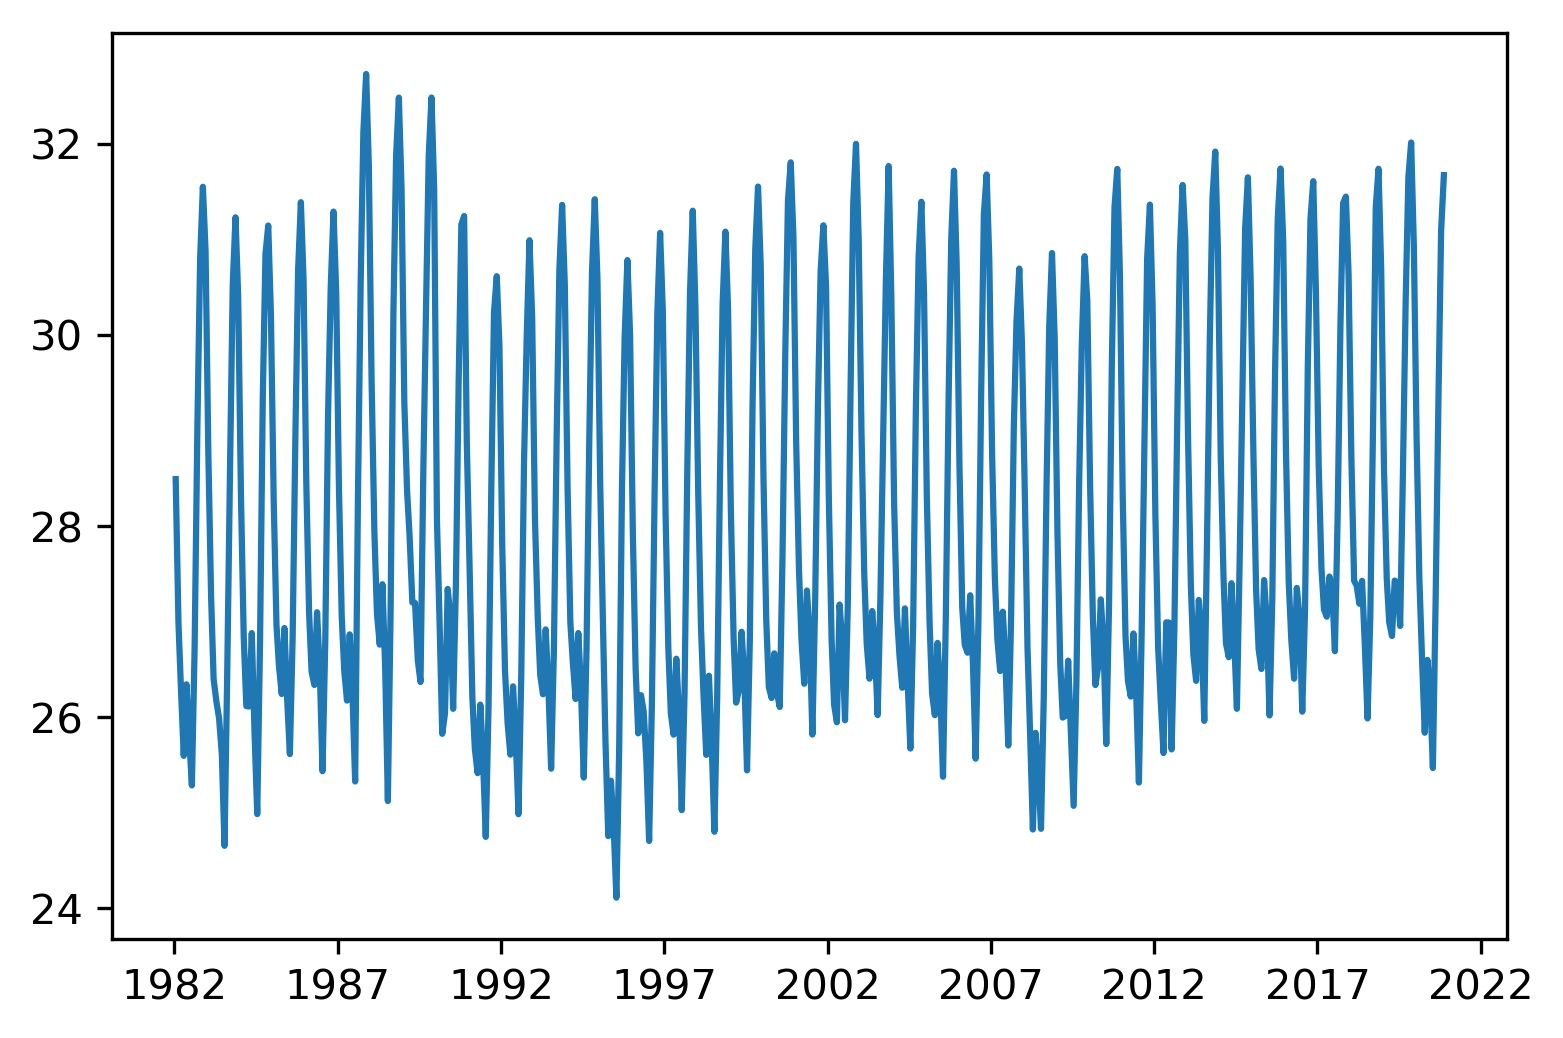

In [27]:
fig = plt.figure()
plt.plot(ds_out.time,ds_out.sss[:,90,130])

In [ ]:
print()